In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd
import json

In [2]:
# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23


In [3]:
directory = current_directory + "\\tif\\"

Fast R-CNN is an evolution of the earlier R-CNN (Region-based Convolutional Neural Networks) and SPPnet (Spatial Pyramid Pooling in deep convolutional networks) models, designed for object detection tasks. Developed by Ross Girshick in 2015, Fast R-CNN improved upon its predecessors in terms of both speed and accuracy.

Functioning of Fast R-CNN:
Input and Feature Extraction:

Fast R-CNN takes an entire image and a set of object proposals as input.
The image is processed by a series of convolutional and max pooling layers to produce a convolutional feature map.


Region of Interest (RoI) Pooling:

For each object proposal, a Region of Interest (RoI) is defined on the feature map.
RoI pooling layer then extracts a fixed-size feature vector from each RoI (regardless of its size), ensuring consistent input size for the subsequent fully connected layers.


Classification and Bounding Box Regression:

These feature vectors are fed into a sequence of fully connected layers that finally branch into two output layers:
One for object classification (which includes a background class for negative samples).
The other for bounding box regression, which refines the positions of the proposed regions.
The classification layer outputs the probabilities of each RoI belonging to each object class.
The regression layer outputs bounding box adjustments for improving the accuracy of the proposed region.
Advantages of Fast R-CNN:
Efficiency: Unlike R-CNN which processes each object proposal independently, Fast R-CNN shares computation on the entire image, making it significantly faster.
Accuracy: It introduces a multi-task loss that combines classification and bounding box regression, leading to improvements in detection accuracy.


Applications:
Fast R-CNN, like other object detection models, is widely used in various applications such as:

Automated vehicle systems for detecting pedestrians, vehicles, and other objects.
Surveillance and security to identify activities and objects of interest.
Industrial automation for defect detection, quality control, and automated assembly.
Retail to automate checkout processes by recognizing products.
Wildlife monitoring for species identification and behavior study.
Limitations:
Despite its improvements, Fast R-CNN still relies on external region proposal algorithms like Selective Search, which can be a bottleneck.
The subsequent development of Faster R-CNN integrated region proposal networks (RPN) directly into the model, further improving both speed and accuracy, addressing one of the main limitations of Fast R-CNN.

In [199]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import tifffile as tiff
import os
import cv2

class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotations = []
        
                # Define the transform for normalization
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),  # Resize if required by your model
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform or transforms.ToTensor()

        # Load annotations
        annotation_files = glob.glob(os.path.join(annotation_folder, '*gt_*.json'))
        for annotation_file in annotation_files:
            with open(annotation_file) as f:
                annotations_data = json.load(f)
                img_name = os.path.basename(annotation_file).replace('gt_', '').replace('.json', '.tif')
                img_path = os.path.join(image_folder, img_name)
                if os.path.exists(img_path):
                    self.annotations.append({'image': img_name, 'bbox': annotations_data})

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_folder, annotation['image'])
        image = tiff.imread(img_path)  # Use tifffile to read the image
        if image is None:
            print(f"Error loading image: {img_path}")
            return None
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if not isinstance(image, torch.Tensor):
            image = self.transform(image)

        rois = []
        bbox = annotation['bbox']
        labels = []  # Assuming you have class labels for each bbox
        gt_boxes = []

        for bbox_data in bbox:
            if len(bbox_data) == 5:
                # If bbox format includes label
                x1, y1, x2, y2, label = bbox_data
            else:
                # If bbox format does not include label, use a default label, e.g., 0 or 1
                x1, y1, x2, y2 = bbox_data
                label = 0  # or 1, depending on your dataset

            labels.append(label)
            gt_boxes.append([x1, y1, x2, y2])

        # Convert to tensors and return
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        sample = {'image': image, 'bbox': gt_boxes_tensor, 'labels': labels_tensor}
        return sample

    def __len__(self):
        return len(self.annotations)

def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch if item is not None], dim=0)
    all_rois = []
    all_labels = []
    all_gt_boxes = []

    for batch_index, item in enumerate(batch):
        if item is not None:
            gt_boxes = item['bbox']
            labels = item['labels']
            for i, (gt_box, label) in enumerate(zip(gt_boxes, labels)):
                all_rois.append([batch_index] + gt_box.tolist())
                all_labels.append(label.item())
                all_gt_boxes.append(gt_box.tolist())

    return {
        'image': images, 
        'rois': torch.tensor(all_rois, dtype=torch.float32), 
        'labels': torch.tensor(all_labels, dtype=torch.int64), 
        'gt_boxes': torch.tensor(all_gt_boxes, dtype=torch.float32)
    }



from torch.utils.data.dataloader import default_collate

# When instantiating the dataset
train_dataset = CustomDataset(
    image_folder=os.path.join(directory, 'reTrain'),
    annotation_folder=os.path.join(directory, 'reTrainJS')
    # transform is None, will use the default one
)

test_dataset = CustomDataset(
    image_folder=os.path.join(directory, 'reTest'),
    annotation_folder=os.path.join(directory, 'reTestJS')
    # transform is None, will use the default one
)


# Then, create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [201]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops import RoIPool, nms

class FastRCNN(nn.Module):
    def __init__(self, num_classes):
        super(FastRCNN, self).__init__()
        self.num_classes = num_classes  # Store num_classes as an instance attribute

        # Load a pre-trained VGG16 model
        base_model = models.vgg16(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the last maxpool layer

        # RoI Pooling
        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=1.0)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        # Bounding Box Regressor
        self.regressor = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes * 4)  # 4 coordinates for each class
        )

    def forward(self, images, rois):
        # Extract feature maps
        feature_maps = self.feature_extractor(images)

        # Convert rois to float tensor if it's not already
        if rois.dtype != torch.float32:
            rois = rois.to(dtype=torch.float32)

        # Apply RoI pooling
        pooled_features = self.roi_pool(feature_maps, rois)

        # Flatten the pooled features
        flattened_features = pooled_features.view(pooled_features.size(0), -1)

        # Classify and regress bounding boxes
        class_logits = self.classifier(flattened_features)
        
        # Correct handling of bbox deltas
        all_bbox_deltas = self.regressor(flattened_features)
        # Reshape to separate class-wise deltas
        bbox_deltas = all_bbox_deltas.view(-1, self.num_classes, 4)
        # Select bbox deltas for the class with the highest probability
        class_probs = torch.softmax(class_logits, dim=1)
        max_probs, max_indices = torch.max(class_probs, dim=1)
        selected_bbox_deltas = bbox_deltas[range(len(max_indices)), max_indices]

        return class_logits, selected_bbox_deltas

# Multi-task Loss
class FastRCNNLoss(nn.Module):
    def __init__(self):
        super(FastRCNNLoss, self).__init__()
        self.cls_loss = nn.CrossEntropyLoss()
        self.reg_loss = nn.SmoothL1Loss()

    def forward(self, class_logits, bbox_deltas, labels, gt_boxes):
        # Classification loss
        classification_loss = self.cls_loss(class_logits, labels)

        # Bounding box regression loss
        regression_loss = self.reg_loss(bbox_deltas, gt_boxes)

        # Combine losses
        total_loss = classification_loss + regression_loss
        return total_loss

# Non-Maximum Suppression
def apply_nms(class_logits, bbox_deltas, threshold=0.5):
    scores, classes = torch.max(class_logits, 1)
    keep = nms(bbox_deltas, scores, threshold)
    return bbox_deltas[keep], classes[keep], scores[keep]

# Instantiate the model and loss function
num_classes = 2  # Including background class
fast_rcnn_model = FastRCNN(num_classes)
fast_rcnn_loss_fn = FastRCNNLoss()

# Example usage
dummy_image = torch.randn(1, 3, 128, 128)
dummy_rois = torch.tensor([[0, 50, 50, 100, 100]])
dummy_labels = torch.tensor([1])
dummy_gt_boxes = torch.tensor([[50, 50, 100, 100]])

class_logits, bbox_deltas = fast_rcnn_model(dummy_image, dummy_rois)
loss = fast_rcnn_loss_fn(class_logits, bbox_deltas, dummy_labels, dummy_gt_boxes)


# Apply NMS during inference
nms_boxes, nms_classes, nms_scores = apply_nms(class_logits, bbox_deltas)

print("Loss:", loss)
print("NMS Boxes:", nms_boxes)
print("NMS Classes:", nms_classes)


Loss: tensor(75.1824, grad_fn=<AddBackward0>)
NMS Boxes: tensor([[ 0.0119, -0.0122,  0.0023,  0.0135]], grad_fn=<IndexBackward0>)
NMS Classes: tensor([1])


This is a basic implementation. You may need to adjust it based on your specific requirements, such as the backbone network, input image size, and the number of classes.
The rois input to the model should be the region proposals in the format [batch_idx, x1, y1, x2, y2]. You can use an external method to generate these proposals or implement an RPN.
The RoIPool layer requires a spatial scale factor (spatial_scale), which depends on the size of your feature maps relative to the original image size.
Training Fast R-CNN involves a more complex setup, including handling of region proposals, multitask loss for classification and regression, and potentially non-maximum suppression for inference.

**_____________________________________________________________________________________**


Non-Maximum Suppression (NMS) in Fast R-CNN:

Purpose:

In object detection tasks, especially with models like Fast R-CNN, the model often predicts multiple bounding boxes around the same object. These boxes may have varying sizes, positions, and confidence scores.
The purpose of NMS is to identify and retain only the best bounding box for each object while discarding the less accurate or redundant boxes.
How It Works:

NMS first looks at the list of all predicted bounding boxes and their associated confidence scores (how confident the model is that the box contains an object of interest).
It starts by selecting the box with the highest confidence score.
Then, it compares this box with all other boxes. If any other box has a significant overlap (determined by a parameter called the Intersection over Union or IoU threshold) with this box, it is considered redundant and removed.
This process is repeated, each time starting with the box with the next highest confidence score that hasn't been compared yet.
The process continues until all boxes have either been kept or discarded.
Why It's Used:

To reduce the number of false positives: Without NMS, you might end up with multiple boxes for the same object, making the output cluttered and less useful.
To improve accuracy: By keeping only the bounding boxes with the highest confidence scores and removing overlaps, NMS helps in making the final output more accurate and easier to interpret.
To streamline the detection process: It simplifies the output by ensuring that each detected object is represented by only one bounding box, making it easier to understand and process further.
Impact on Fast R-CNN:

In Fast R-CNN, NMS plays a crucial role in the post-processing stage. After the region proposal network (RPN) suggests potential object regions and the Fast R-CNN head predicts class scores and bounding box refinements, NMS is applied to filter these predictions.
The result is a cleaner, more precise set of bounding boxes that the model can use to accurately identify and locate objects within an image.

**____________________________________________________---**

In Fast R-CNN and similar object detection models, the performance and loss are influenced by several factors. Understanding these can help you optimize your model for better results. Here are some key aspects to consider:

Region of Interest (RoI) Generation:

In Fast R-CNN, RoIs are rectangular regions that potentially contain objects. These are fed into the network for classification and bounding box regression.
Initially, you're generating RoIs using a custom method based on your dataset annotations. This approach can work but might not be optimal.
Region Proposal Network (RPN): This is a part of the Faster R-CNN architecture. It's a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals.
Using a Pretrained RPN: Implementing an RPN or using a pretrained one (like from a pretrained Faster R-CNN model) can significantly improve the quality of region proposals, leading to better performance of the Fast R-CNN model.
Model Architecture and Parameters:

Backbone Network: The choice of the backbone network (like VGG16, ResNet, etc.) for feature extraction can significantly affect performance. Pretrained networks on large datasets (like ImageNet) often provide a good starting point.
Classifier and Regressor Layers: The architecture of the fully connected layers for classification and bounding box regression can be fine-tuned. More layers or neurons can capture complex patterns but might lead to overfitting.
Loss Function: The loss function in Fast R-CNN typically includes a classification loss (like CrossEntropyLoss) and a regression loss (like SmoothL1Loss). Balancing these two components is crucial for training stability and performance.
Training Hyperparameters:

Learning Rate: A proper learning rate is crucial. Too high can lead to divergence, too low might result in slow convergence.
Batch Size: Affects the gradient estimation. Larger batches provide more stable gradients but require more memory.
Optimizer: Different optimizers (like Adam, SGD) have different convergence properties.
Regularization: Techniques like dropout and weight decay (L2 regularization) can help prevent overfitting.
Data Quality and Augmentation:

The quality and diversity of the training data significantly influence model performance.
Data augmentation (like rotations, flipping, scaling) can improve the robustness and generalizability of the model.
Non-Maximum Suppression (NMS):

NMS is used during inference to eliminate redundant overlapping bounding boxes. It ensures that each object is detected only once.
The threshold for NMS can be tuned based on how much overlap you expect between bounding boxes for different objects.
Region Proposal Quality:

The quality of region proposals directly impacts the final detection performance. Better proposals mean the model can focus on learning finer classification and regression tasks.
Implementing or utilizing a pretrained RPN from a model like Faster R-CNN can significantly enhance the initial region proposals' quality, leading to overall better performance of your Fast R-CNN model. Additionally, fine-tuning the various aspects mentioned above can lead to a reduction in loss and improved detection accuracy.

In [202]:
import torch

num_classes = 2

# Instantiate the model
fast_rcnn_model = FastRCNN(num_classes)  # Assuming FastRCNN is your model class
fast_rcnn_model.eval()  # Set the model to evaluation mode

# Create a dummy image (batch size, number of channels, height, width)
# Adjust the size according to your network's input requirements
dummy_image = torch.randn(1, 3, 224, 224)

# Create dummy RoIs (number of RoIs, 5 elements: batch_index, x1, y1, x2, y2)
# Here, we create one RoI for simplicity
dummy_rois = torch.tensor([[0, 50, 50, 100, 100]], dtype=torch.float32)

# Pass the dummy data through the model
with torch.no_grad():
    class_logits, bbox_deltas = fast_rcnn_model(dummy_image, dummy_rois)

# Print the shapes of the outputs
print("Shape of class logits:", class_logits.shape)
print("Shape of bounding box deltas:", bbox_deltas.shape)


Shape of class logits: torch.Size([1, 2])
Shape of bounding box deltas: torch.Size([1, 4])


In [217]:

import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Instantiate the model
fast_rcnn_model = FastRCNN(num_classes=2)  # Include the number of classes
fast_rcnn_model.to(device)  # Move the model to the device

# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Optimizer
optimizer = torch.optim.Adam(fast_rcnn_model.parameters(), lr=learning_rate)

def train_model(model, train_loader, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            rois = batch['rois'].to(device)  # RoIs for each image
            labels = batch['labels'].to(device)  # Class labels for each RoI
            gt_boxes = batch['gt_boxes'].to(device)  # Ground truth boxes for each RoI

            # Forward pass
            class_logits, bbox_deltas = model(images, rois)

            # Calculate loss
            loss = fast_rcnn_loss_fn(class_logits, bbox_deltas, labels, gt_boxes)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fast_rcnn_model.to(device)
optimizer = torch.optim.Adam(fast_rcnn_model.parameters(), lr=0.001)

train_model(fast_rcnn_model, train_loader, optimizer, num_epochs=25, device=device)

Training on device: cpu
Epoch [1/25], Loss: 61.7246
Epoch [2/25], Loss: 33.6550
Epoch [3/25], Loss: 29.8071
Epoch [4/25], Loss: 29.6191
Epoch [5/25], Loss: 29.3690
Epoch [6/25], Loss: 29.5384
Epoch [7/25], Loss: 29.4347
Epoch [8/25], Loss: 29.4596
Epoch [9/25], Loss: 29.4527
Epoch [10/25], Loss: 29.5356
Epoch [11/25], Loss: 29.5615
Epoch [12/25], Loss: 29.4852
Epoch [13/25], Loss: 29.4501
Epoch [14/25], Loss: 29.4998
Epoch [15/25], Loss: 29.5901
Epoch [16/25], Loss: 29.5649
Epoch [17/25], Loss: 29.5516
Epoch [18/25], Loss: 29.5346
Epoch [19/25], Loss: 29.5202
Epoch [20/25], Loss: 29.5369
Epoch [21/25], Loss: 29.5148
Epoch [22/25], Loss: 29.4528
Epoch [23/25], Loss: 29.4942
Epoch [24/25], Loss: 29.6103
Epoch [25/25], Loss: 29.5344


IndexError: invalid index to scalar variable.

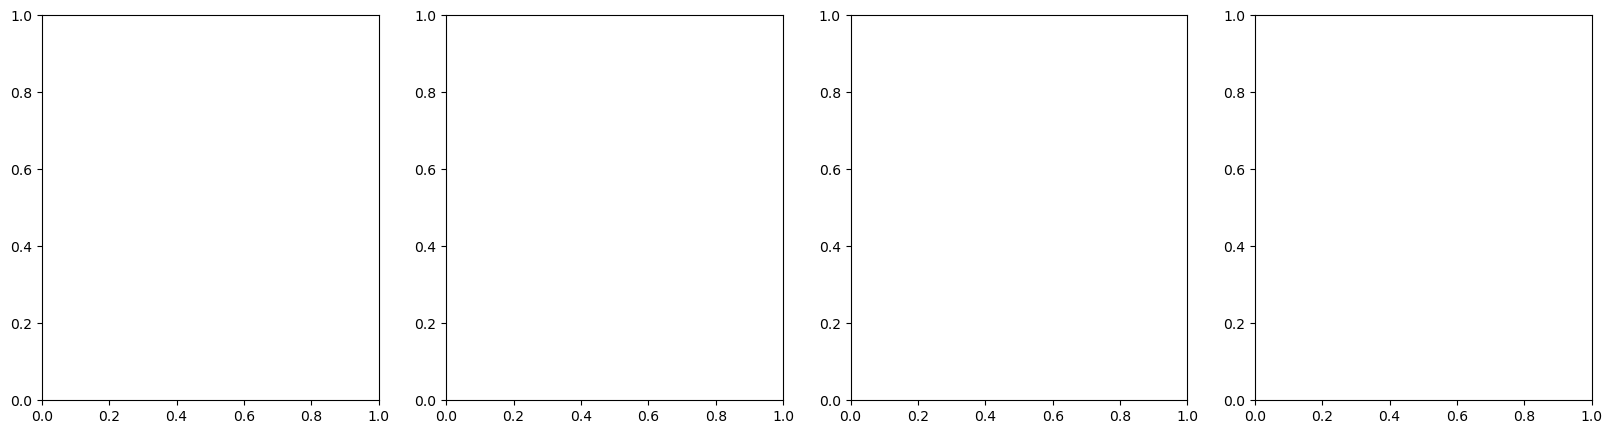

In [218]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(ax, bboxes, color="red"):
    for bbox in bboxes:
        # bbox is in the format [x1, y1, x2, y2]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

def plot_sample_images(data_loader, model, device, num_samples=4):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get a batch of data
        batch = next(iter(data_loader))
        images = batch['image'].to(device)
        # Assuming that rois are needed, you might need to create them here or get them from the batch if available
        rois = batch['rois'].to(device) if 'rois' in batch else None  # Example, replace with your actual rois
        predictions = model(images, rois)  # Pass the rois if needed

        fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))
        for i in range(num_samples):
            # Convert image to numpy and transpose from CxHxW to HxWxC for plotting
            img_np = images[i].cpu().numpy().transpose((1, 2, 0))
            img_np = (img_np * 255).astype(np.uint8)  # Convert from float to uint8
            
            # Draw ground truth boxes in blue
            gt_bboxes = batch['gt_boxes'][i].cpu().numpy()
            draw_bounding_boxes(axs[i], gt_bboxes, color="blue")
            
            # Draw predicted boxes in red, assuming predictions are structured similarly to targets
            pred_bboxes = predictions[i]['boxes'].cpu().numpy()
            draw_bounding_boxes(axs[i], pred_bboxes, color="red")
            
            axs[i].imshow(img_np)
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()

# Example usage
plot_sample_images(train_loader, fast_rcnn_model, device, num_samples=4)


**Now implementing same model with pretrained RPNs**

1. Feature Pyramid Network (FPN) Benefits:
Multi-Scale Feature Representation: FPN enhances the backbone network (like ResNet) to create a pyramid of feature maps at different scales. This is particularly effective for detecting objects of various sizes, which is a common challenge in object detection.
Rich Semantic Information at All Levels: Unlike traditional convolutional backbones that might lose semantic information at higher levels (deeper layers), FPN maintains rich semantic information across all levels of the feature pyramid. This enhances the quality of the features used for both region proposal (by RPN) and object classification.
2. Pre-Trained RPN Benefits:
Efficient Region Proposals: The pre-trained RPN is optimized to propose candidate object regions (region proposals) efficiently. It is trained to distinguish between background and potential objects, making it a robust starting point for any object detection model.
Compatibility with FPN: When you use an RPN from a model like fasterrcnn_resnet50_fpn, it's already configured to work with multi-scale feature maps generated by the FPN. This ensures that the region proposals are informed by comprehensive feature representations at multiple scales.
3. Overall Model Enhancement:
Accuracy: By leveraging both FPN and a pre-trained RPN, the model can achieve higher accuracy, especially in detecting objects of various sizes and in complex scenes.
Speed and Efficiency: Despite the increased complexity, such models can be surprisingly efficient. The multi-scale approach of FPN reduces the need for processing images at multiple resolutions, and the pre-trained RPN can quickly generate high-quality region proposals.
Transfer Learning: Using components (like RPN) from pre-trained models allows leveraging knowledge from large datasets, which can be particularly beneficial when training data for the specific task is limited.
Why This Works Better Than Using RPN Alone:
RPN alone can propose regions, but it might not be as effective in handling the wide variety of object sizes and shapes encountered in real-world scenarios.
FPN integration ensures that the RPN has access to multi-scale, semantically rich features, improving its ability to propose regions that are more likely to contain objects.
The combination of FPN's rich feature representation and RPN's efficient proposal mechanism results in a more robust and versatile object detection framework.
In summary, this integrated approach takes advantage of the strengths of both FPN and RPN, leading to a more powerful and adaptable object detection model.

In [315]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import tifffile as tiff
import os
import cv2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    normalize
])



class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotations = []
        self.transform = transform or transforms.ToTensor()

        # Load annotations
        annotation_files = glob.glob(os.path.join(annotation_folder, '*gt_*.json'))
        for annotation_file in annotation_files:
            with open(annotation_file) as f:
                annotations_data = json.load(f)
                img_name = os.path.basename(annotation_file).replace('gt_', '').replace('.json', '.tif')
                img_path = os.path.join(image_folder, img_name)
                if os.path.exists(img_path):
                    self.annotations.append({'image': img_name, 'bbox': annotations_data})

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_folder, annotation['image'])
        image = tiff.imread(img_path)  # Use tifffile to read the image
        if image is None:
            print(f"Error loading image: {img_path}")
            return None
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if not isinstance(image, torch.Tensor):
            image = self.transform(image)

        rois = []
        bbox = annotation['bbox']
        labels = []  # Assuming you have class labels for each bbox
        gt_boxes = []

        for bbox_data in bbox:
            x1, y1, x2, y2 = bbox_data[:4]
            label = 1  # Assigning class 1 for all actual bounding boxes
            gt_boxes.append([x1, y1, x2, y2])
            labels.append(label)

        # Convert to tensors and return
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        sample = {'image': image, 'bbox': gt_boxes_tensor, 'labels': labels_tensor}
        
        
        return sample

    def __len__(self):
        return len(self.annotations)

def collate_fn(batch):
    images = []
    targets = []
    
    for item in batch:
        if item is not None:
            images.append(item['image'])
            targets.append({'boxes': item['bbox'], 'labels': item['labels']})
            
    return images, targets


from torch.utils.data.dataloader import default_collate

# Load dataset
train_dataset = CustomDataset(image_folder=os.path.join(directory, 'reTrain'), 
                              annotation_folder=os.path.join(directory, 'reTrainJS'), 
                              transform=transform)
test_dataset = CustomDataset(image_folder=os.path.join(directory, 'reTest'), 
                              annotation_folder=os.path.join(directory, 'reTestJS'), 
                              transform=transform)


# Then, create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [316]:
np.unique(labels)

array([0], dtype=int64)

In [317]:
import torch
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class FastRCNNFPN(nn.Module):
    def __init__(self, num_classes):
        super(FastRCNNFPN, self).__init__()
        # Load a pre-trained Faster R-CNN model with FPN
        self.model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        # Replace the classifier and box predictor of the ROI heads
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    def forward(self, images, targets=None):
        # The Faster R-CNN model with FPN handles feature extraction and RPN internally
        return self.model(images, targets)

# Instantiate the model
num_classes = 2  # Including background class
fast_rcnn_model = FastRCNNFPN(num_classes)

# Assuming your model is named `fast_rcnn_model` and it's already moved to the appropriate device
optimizer = torch.optim.Adam(fast_rcnn_model.parameters(), lr=0.001)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In your training code, the loss is calculated by the fasterrcnn_resnet50_fpn model, which is a pre-built model from the torchvision.models.detection module. This model is designed to handle both the calculation of predictions and the computation of loss internally when provided with ground truth data during training.

In [ ]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
num_classes = 2  # Including background class
fast_rcnn_model = FastRCNNFPN(num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(fast_rcnn_model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    fast_rcnn_model.train()  # Set the model to training mode
    epoch_loss = 0

    for images, targets in train_loader:
        # Prepare data for model
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = fast_rcnn_model(images, targets)
        
        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += total_loss.item()
    
    # Print the epoch's loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')


Epoch 1/5, Total Loss: 102.30542123317719


In [308]:
@torch.no_grad()
def evaluate_and_plot(model, data_loader, device, num_images=2, threshold=0.5):
    model.eval()
    images, targets = next(iter(data_loader))
    images = list(img.to(device) for img in images)
    predictions = model(images)

    for i in range(num_images):
        # Print predictions before thresholding
        print(f"Image {i+1} Predictions (before threshold):")
        prediction = predictions[i]
        print("Boxes:", prediction['boxes'])
        print("Labels:", prediction['labels'])
        print("Scores:", prediction['scores'])

        image = images[i].cpu()
        # If the image was normalized, we need to reverse the process
        if image.dtype == torch.float32:
            # Assuming that normalization was applied, these are the common mean and std values
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])
            image = image * std[:, None, None] + mean[:, None, None]
            image = torch.clamp(image, 0, 1)
            image = (image * 255).type(torch.uint8)

        target = targets[i]
        prediction = predictions[i]

        # Apply threshold
        pred_boxes = prediction['boxes'][prediction['scores'] > threshold]
        pred_scores = prediction['scores'][prediction['scores'] > threshold]

        # Draw ground truth and prediction boxes
        image_with_gt = draw_bounding_boxes(image, target['boxes'].cpu(), colors="blue", width=2)
        image_with_pred = draw_bounding_boxes(image, pred_boxes.cpu(), colors="red", width=2)

        # Print out the filtered predictions
        print(f"Image {i+1} Predictions (after threshold):")
        for j, (box, score) in enumerate(zip(pred_boxes, pred_scores)):
            print(f"Box {j}: {box.cpu()}, Score: {score.cpu()}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image_with_gt.permute(1, 2, 0).numpy())
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_with_pred.permute(1, 2, 0).numpy())
        plt.title('Predictions')
        plt.axis('off')

        plt.show()

# Call the function to evaluate and plot predictions
evaluate_and_plot(fast_rcnn_model, val_loader, device, num_images=2)


Debug in collate_fn - images type: <class 'torch.Tensor'>, shape: torch.Size([8, 3, 512, 512])
Debug in collate_fn - targets type: <class 'list'>, length: 8
Image 1 Predictions (before threshold):
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
Scores: tensor([])


KeyError: 'boxes'

**# Now implementing different pretrained backbone for this fastR-CNN**

In [228]:
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone

def get_mobilenet_backbone(pretrained=True):
    backbone = mobilenet_backbone('mobilenet_v2', pretrained=pretrained, fpn=True)
    return backbone

# Create the FastRCNN model with a MobileNetV2 backbone
num_classes = 2  # Including background class
backbone = get_mobilenet_backbone(pretrained=True)
model_mobilenet = FasterRCNN(backbone, num_classes=num_classes)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [230]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
num_classes = 2  # Including background class
model_mobilenet = FastRCNNFPN(num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model_mobilenet.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_mobilenet.train()  # Set the model to training mode
    epoch_loss = 0

    for images, targets in train_loader:
        # Prepare data for model
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model_mobilenet(images, targets)
        
        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += total_loss.item()
    
    # Print the epoch's loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')


Epoch 1/5, Total Loss: 50.233904272317886
Epoch 2/5, Total Loss: 8.266858369112015
Epoch 3/5, Total Loss: 6.2535132467746735
Epoch 4/5, Total Loss: 5.4232867658138275
Epoch 5/5, Total Loss: 5.071722164750099


Image 1 Predictions (before threshold):
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
Scores: tensor([])
Image 1 Predictions (after threshold):


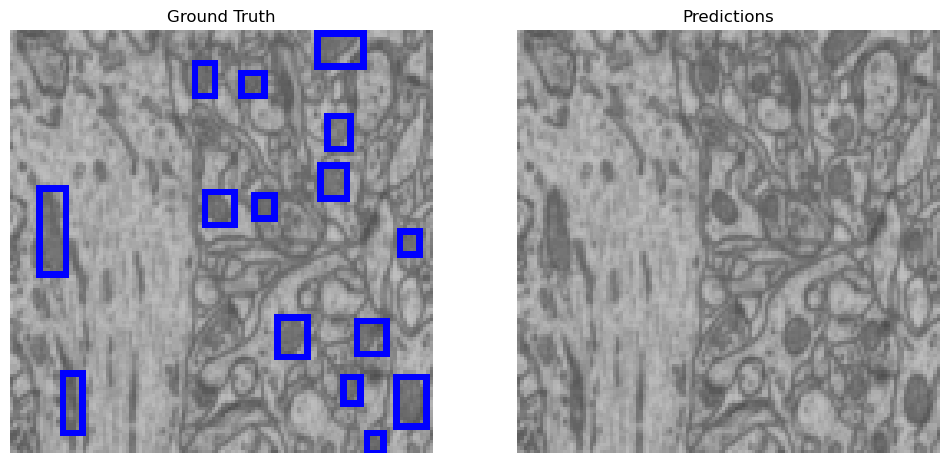

Image 2 Predictions (before threshold):
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
Scores: tensor([])
Image 2 Predictions (after threshold):


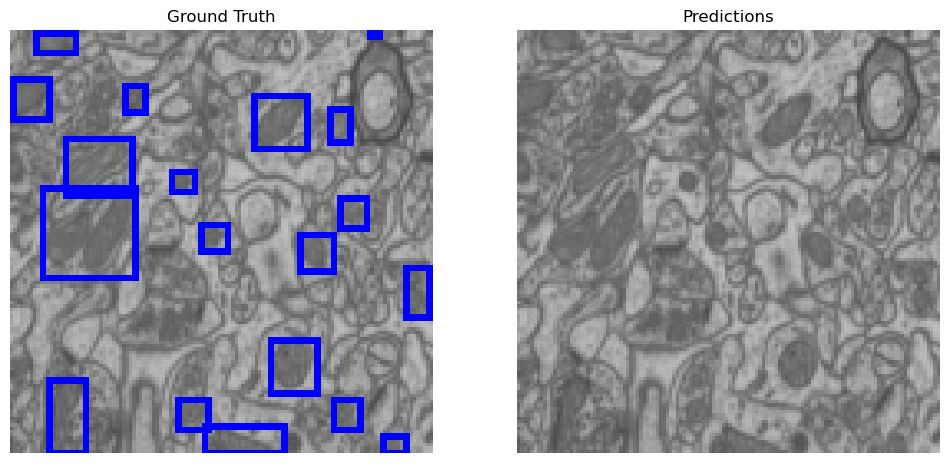

In [234]:
# Call the function to evaluate and plot predictions
evaluate_and_plot(model_mobilenet, val_loader, device, num_images=2)


In [229]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.models as models

def get_densenet_backbone(pretrained=True, backbone_name='densenet121'):
    # Load a pre-trained DenseNet model
    if backbone_name == 'densenet121':
        densenet_backbone = models.densenet121(pretrained=pretrained).features
    elif backbone_name == 'densenet169':
        densenet_backbone = models.densenet169(pretrained=pretrained).features
    # DenseNet uses `norm5` as its last layer, so we rename it.
    densenet_backbone.out_channels = 1024  # Adjust the number of output channels
    return densenet_backbone

# Create the FastRCNN model with a DenseNet backbone
num_classes = 2  # Including background class
backbone = get_densenet_backbone(pretrained=True, backbone_name='densenet121')
model_densenet = FasterRCNN(backbone, num_classes=num_classes)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\prana/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:00<00:00, 72.9MB/s]


In [231]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
num_classes = 2  # Including background class
model_densenet = FastRCNNFPN(num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model_densenet.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_densenet.train()  # Set the model to training mode
    epoch_loss = 0

    for images, targets in train_loader:
        # Prepare data for model
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model_densenet(images, targets)
        
        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += total_loss.item()
    
    # Print the epoch's loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')


Epoch 1/5, Total Loss: 488.235453158617
Epoch 2/5, Total Loss: 105.02718013525009
Epoch 3/5, Total Loss: 9.05710881948471
Epoch 4/5, Total Loss: 8.124888628721237
Epoch 5/5, Total Loss: 7.736701428890228


Image 1 Predictions (before threshold):
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
Scores: tensor([])
Image 1 Predictions (after threshold):


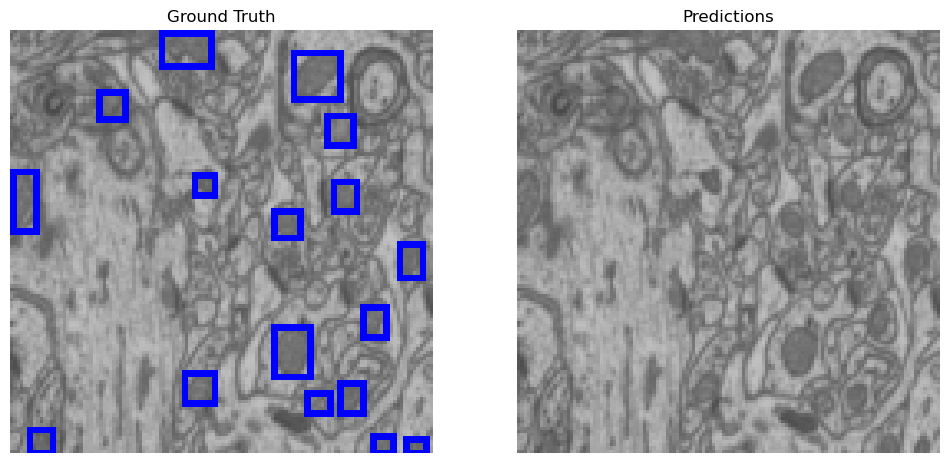

Image 2 Predictions (before threshold):
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
Scores: tensor([])
Image 2 Predictions (after threshold):


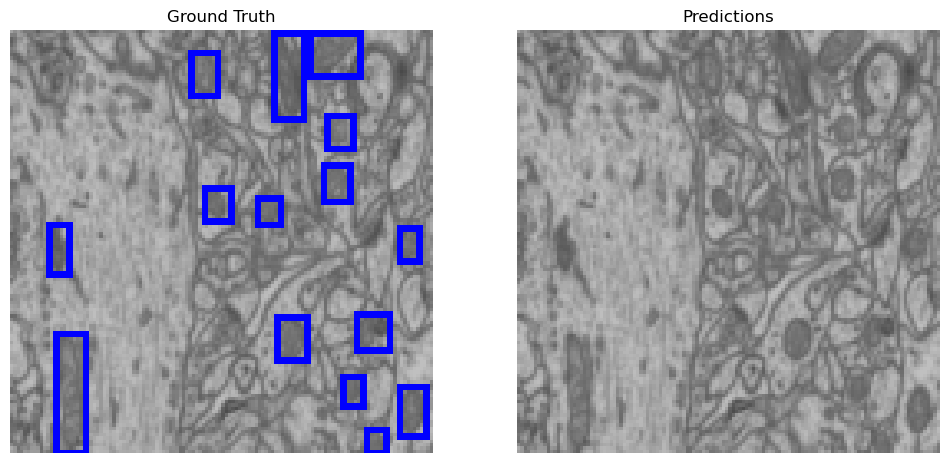

In [233]:
# Call the function to evaluate and plot predictions
evaluate_and_plot(model_densenet, val_loader, device, num_images=2)


In [238]:
pip install effdet

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.10.0 which is incompatible.


  Obtaining dependency information for effdet from https://files.pythonhosted.org/packages/9c/13/563119fe0af82aca5a3b89399c435953072c39515c2e818eb82793955c3b/effdet-0.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for timm>=0.9.2 from https://files.pythonhosted.org/packages/01/a5/eeb717242343d9ca34e7de554a6c08d96a0cfc7005ece4f847b1753581a6/timm-0.9.12-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
  Obtaining dependency information for pycocotools>=2.0.2 from https://files.pythonhosted.org/packages/24/b2/ef28a34cf6ca50b6b2f7ad81e5837ed45c252ffef22f5a704b94141ea842/pycocotools-2.0.7-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/79.5 kB ? eta -:--:--
     ---------------------------------------- 79.5/79.5 kB ? eta 0:00:00
     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     ----